In [2]:
from keras.layers import Input, Dense
from keras.models import Model, Sequential
from keras import regularizers
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, accuracy_score
from sklearn.manifold import TSNE
from sklearn import preprocessing
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import seaborn as sns
import tensorflow as tf
# import tensorflow_probability as tfp
from sklearn.metrics import precision_score, recall_score, confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay
from matplotlib import gridspec
from sklearn.decomposition import PCA
sns.set(style="whitegrid")
np.random.seed(203)

In [3]:
data = pd.read_csv("creditcard.csv")
data["Time"] = data["Time"].apply(lambda x : x / 3600 % 24)
data.head()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.000000,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.000000,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,0.000278,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,0.000278,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,0.000556,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


In [4]:
vc = data['Class'].value_counts().to_frame().reset_index()
vc['percent'] = vc["Class"].apply(lambda x : round(100*float(x) / len(data), 2))
vc = vc.rename(columns = {"index" : "Target", "Class" : "Count"})
vc

,Count,count,percent
0,0,284315,0.0
1,1,492,0.0


In [5]:
non_fraud = data[data['Class'] == 0].sample(5000)
fraud = data[data['Class'] == 1]

df = pd.concat([non_fraud, fraud]).sample(frac=1).reset_index(drop=True)

X = df.drop(['Class'], axis=1).values
Y = df["Class"].values

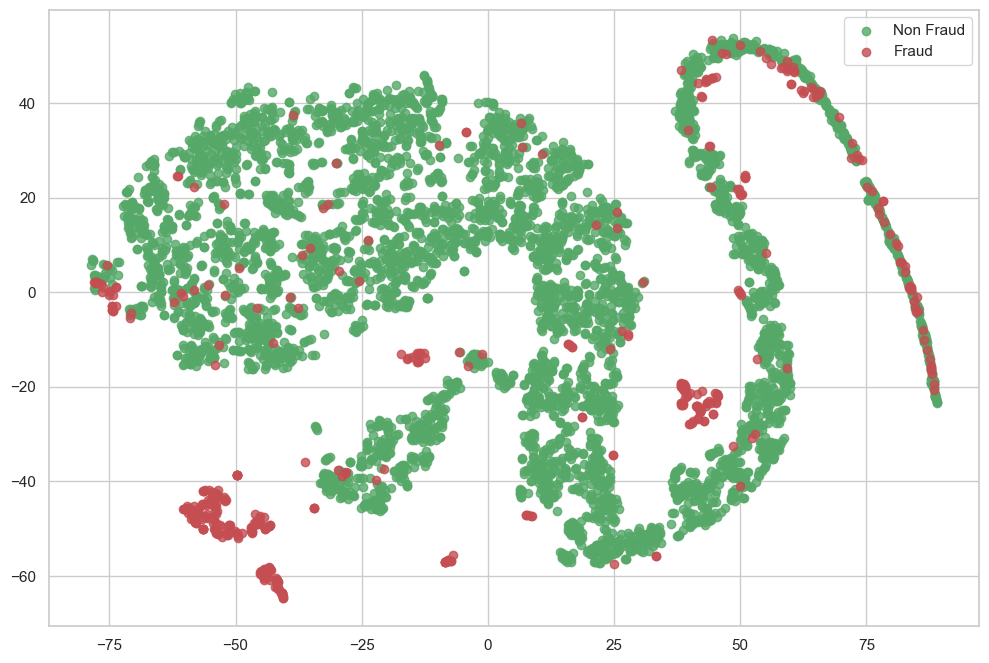

In [6]:
def tsne_plot(x1, y1):
    tsne = TSNE(n_components=2, random_state=0)
    X_t = tsne.fit_transform(x1)

    plt.figure(figsize=(12, 8))
    plt.scatter(X_t[np.where(y1 == 0), 0], X_t[np.where(y1 == 0), 1], marker='o', color='g', linewidth=1, alpha=0.8, label='Non Fraud')
    plt.scatter(X_t[np.where(y1 == 1), 0], X_t[np.where(y1 == 1), 1], marker='o', color='r', linewidth=1, alpha=0.8, label='Fraud')

    plt.legend(loc='best')
    plt.show()

tsne_plot(X, Y)

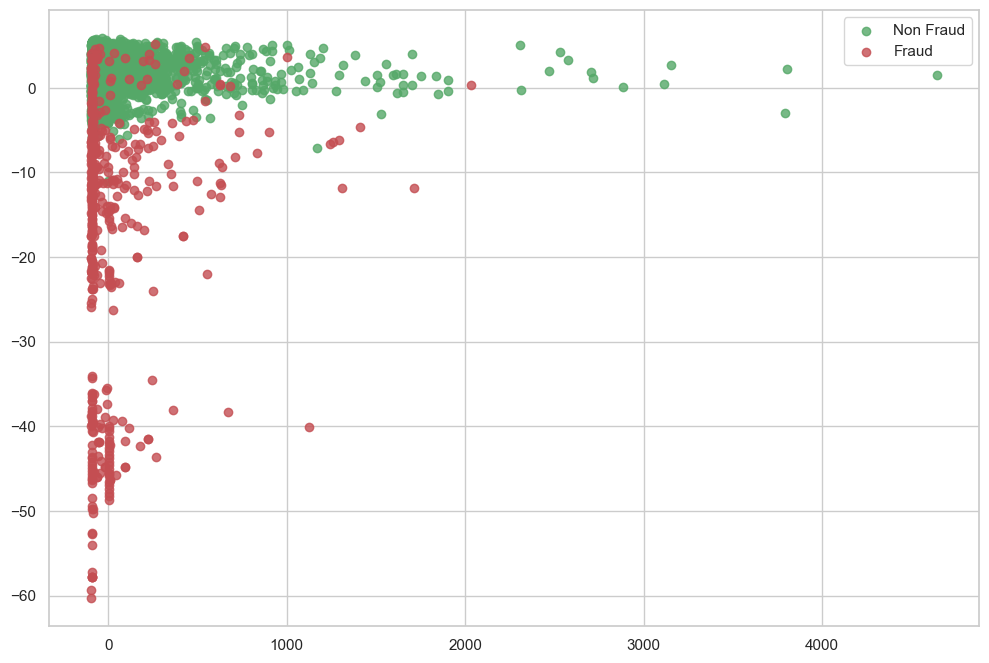

In [7]:
def pca_plot(x1, y1):
    pca = PCA(n_components=2, random_state=0)
    X_t = pca.fit_transform(x1)

    plt.figure(figsize=(12, 8))
    plt.scatter(X_t[np.where(y1 == 0), 0], X_t[np.where(y1 == 0), 1], marker='o', color='g', linewidth=1, alpha=0.8, label='Non Fraud')
    plt.scatter(X_t[np.where(y1 == 1), 0], X_t[np.where(y1 == 1), 1], marker='o', color='r', linewidth=1, alpha=0.8, label='Fraud')

    plt.legend(loc='best')
    plt.show()

pca_plot(X, Y)

In [8]:
def plot_loss(hist):
    plt.plot(hist.history['loss'])
    plt.plot(hist.history['val_loss'])
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')
    plt.yscale('log',basey=10)
    plt.show()

In [10]:
## input layer 
input_layer = Input(shape=(X.shape[1],))

## encoding part
encoded = Dense(100, activation='tanh', activity_regularizer=regularizers.l1(10e-5))(input_layer)
encoded = Dense(50, activation='relu')(encoded)

## decoding part
decoded = Dense(50, activation='tanh')(encoded)
decoded = Dense(100, activation='tanh')(decoded)

## output layer
output_layer = Dense(X.shape[1], activation='relu')(decoded)

In [11]:
autoencoder = Model(input_layer, output_layer)
autoencoder.compile(optimizer="adadelta", loss="mse")

In [12]:
x = data.drop(["Class"], axis=1)
y = data["Class"].values

x_scale = preprocessing.MinMaxScaler().fit_transform(x.values)
x_norm, x_fraud = x_scale[y == 0], x_scale[y == 1]

In [13]:
autoencoder.fit(x_norm[0:10000], x_norm[0:10000],
                batch_size = 256, epochs = 50,
                shuffle = True, validation_split = 0.20);

Epoch 1/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.9514 - val_loss: 0.9485
Epoch 2/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.9489 - val_loss: 0.9460
Epoch 3/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.9463 - val_loss: 0.9436
Epoch 4/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.9437 - val_loss: 0.9410
Epoch 5/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.9413 - val_loss: 0.9384
Epoch 6/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.9385 - val_loss: 0.9357
Epoch 7/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.9357 - val_loss: 0.9330
Epoch 8/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.9332 - val_loss: 0.9301
Epoch 9/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.9301 - val_loss: 0.9272
Epoch 10/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.9270 - val_loss: 0.9243
Epoch 11/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.9241 - val_loss: 0.9213
Epoch 12/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.9212 - val_lo

In [14]:
hidden_representation = Sequential()
hidden_representation.add(autoencoder.layers[0])
hidden_representation.add(autoencoder.layers[1])
hidden_representation.add(autoencoder.layers[2])

In [15]:
norm_hid_rep = hidden_representation.predict(x_norm[-10000:])
fraud_hid_rep = hidden_representation.predict(x_fraud)

313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 298us/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 305us/step


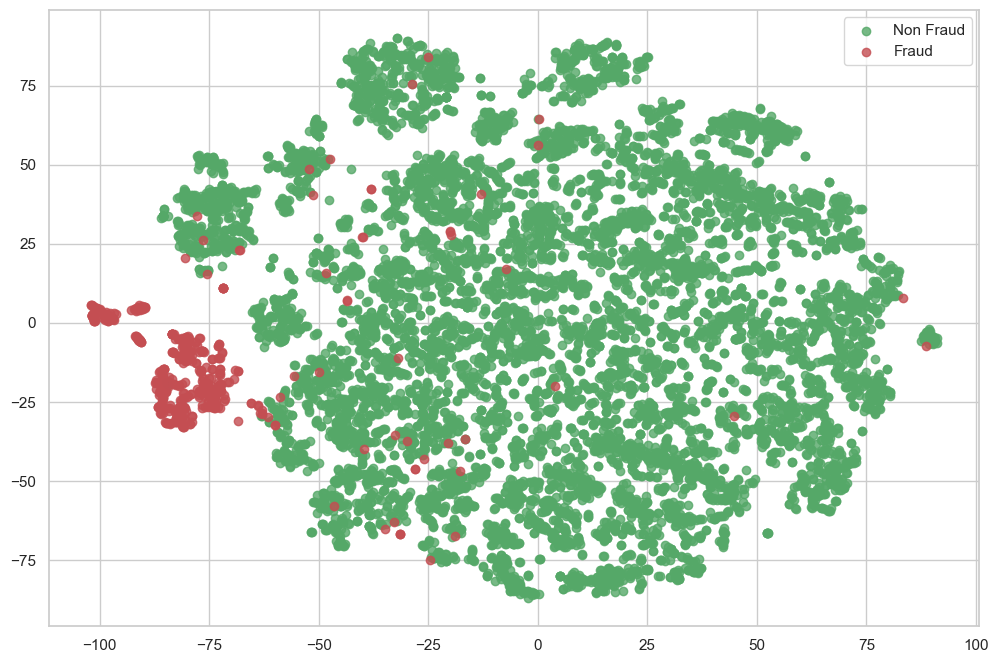

In [16]:
rep_x = np.append(norm_hid_rep, fraud_hid_rep, axis = 0)
y_n = np.zeros(norm_hid_rep.shape[0])
y_f = np.ones(fraud_hid_rep.shape[0])
rep_y = np.append(y_n, y_f)
tsne_plot(rep_x, rep_y)

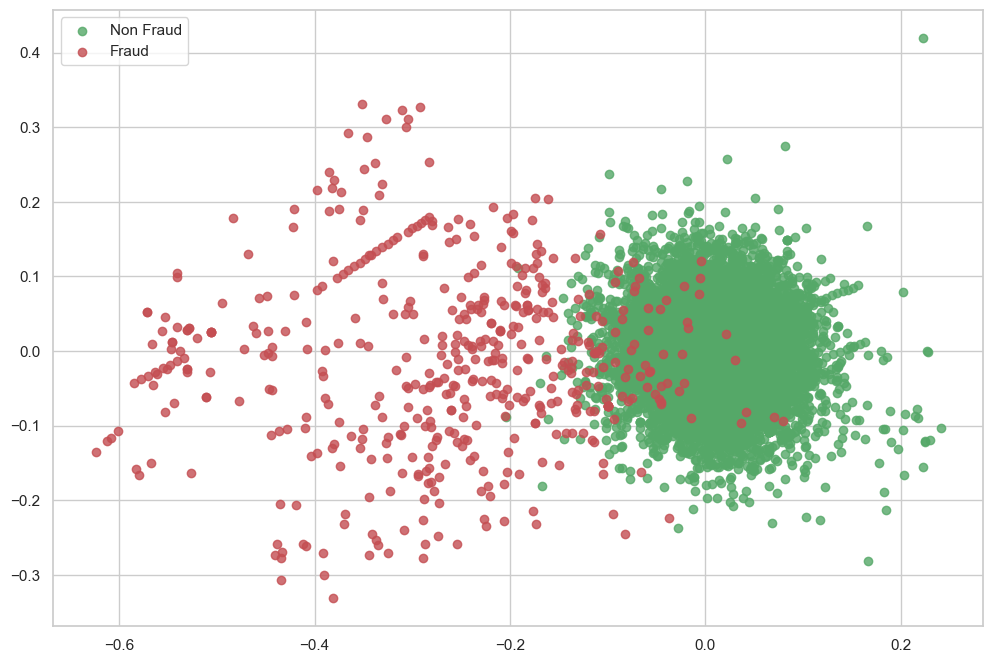

In [17]:
rep_x = np.append(norm_hid_rep, fraud_hid_rep, axis = 0)
y_n = np.zeros(norm_hid_rep.shape[0])
y_f = np.ones(fraud_hid_rep.shape[0])
rep_y = np.append(y_n, y_f)
pca_plot(rep_x, rep_y)

In [19]:
train_x, val_x, train_y, val_y = train_test_split(rep_x, rep_y, test_size=0.25)
clf = LogisticRegression(solver="lbfgs").fit(train_x, train_y)
pred_y = clf.predict(val_x)
train_pred = clf.predict(train_x)

print ("")
print ("Classification Report: ")
print (classification_report(val_y, pred_y))

print ("")
print ("Accuracy Score: ", accuracy_score(val_y, pred_y))


Classification Report: 
              precision    recall  f1-score   support

         0.0       0.98      1.00      0.99      2490
         1.0       1.00      0.64      0.78       133

    accuracy                           0.98      2623
   macro avg       0.99      0.82      0.89      2623
weighted avg       0.98      0.98      0.98      2623


Accuracy Score:  0.9817003431185666


Precision: 1.00
Recall: 0.64
Precision: 1.00
Recall: 0.65


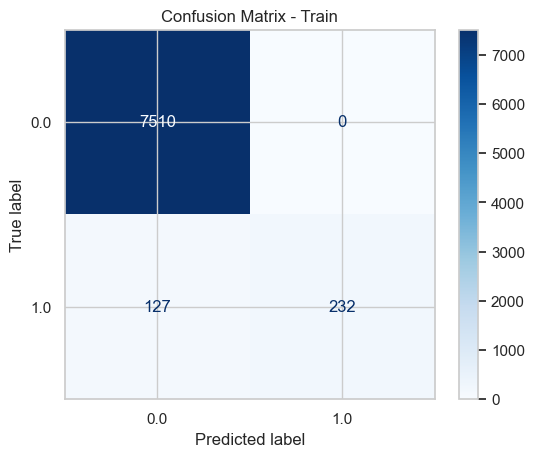

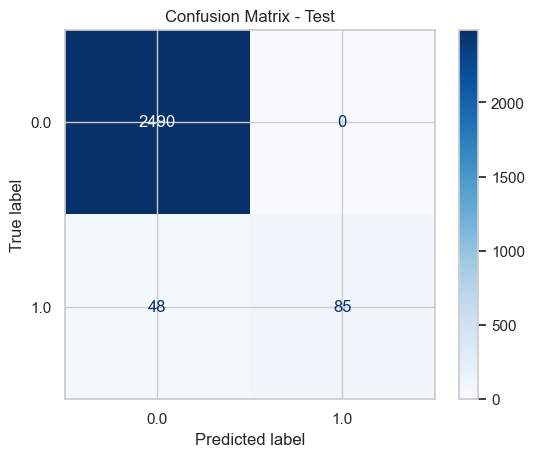

In [21]:
y_test_pred = pred_y

train_precision = precision_score(train_y, train_pred)
train_recall = recall_score(train_y, train_pred)
test_precision = precision_score(val_y, y_test_pred)
test_recall = recall_score(val_y, y_test_pred)

print(f"Precision: {test_precision:.2f}")
print(f"Recall: {test_recall:.2f}")
print(f"Precision: {train_precision:.2f}")
print(f"Recall: {train_recall:.2f}")


train_conf_matrix = confusion_matrix(train_y, train_pred)
disp_test = ConfusionMatrixDisplay(confusion_matrix=train_conf_matrix, display_labels=clf.classes_)
disp_test.plot(cmap=plt.cm.Blues)
plt.title("Confusion Matrix - Train")


test_conf_matrix = confusion_matrix(val_y, y_test_pred)
disp_test = ConfusionMatrixDisplay(confusion_matrix=test_conf_matrix, display_labels=clf.classes_)
disp_test.plot(cmap=plt.cm.Blues)
plt.title("Confusion Matrix - Test")

plt.show()